In [ ]:
# Сколько символов поместится в ваш блокнот?
width = 112
print('A'*width)

import numpy as np

np.set_printoptions(linewidth=width)
np.arange(width)

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111])

In [ ]:
import pandas as pd
pd.options.display.width = width - 10
pd.options.display.max_colwidth = width - 10
pd.DataFrame([{'col': 'A' * (width-11)}])

,col
0,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA


# Установка, запуск, предобработка

In [ ]:
!apt-get install -q openjdk-8-jdk-headless
!wget -c https://apache-mirror.rbc.ru/pub/apache/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!if [ ! -d spark-3.2.1-bin-hadoop3.2 ]; then tar -xzf spark-3.2.1-bin-hadoop3.2.tgz; fi
!pip install findspark

Reading package lists...
Building dependency tree...
Reading state information...
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b

In [ ]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [ ]:
ch_train = spark.read.csv('/content/sample_data/california_housing_train.csv', header=True, inferSchema=True)
ch_test = spark.read.csv('/content/sample_data/california_housing_test.csv', header=True, inferSchema=True)

ch = ch_train.union(ch_test)
ch.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)



In [ ]:
ch.sample(False, 0.001, seed=0).show()

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|  -116.95|   32.78|              33.0|     2432.0|         443.0|    1147.0|     427.0|       3.3906|          138100.0|
|  -117.25|   34.16|              31.0|     1516.0|         238.0|     596.0|     255.0|       4.3362|          159400.0|
|  -117.97|   34.01|              33.0|     3530.0|         700.0|    2959.0|     679.0|       3.7459|          152900.0|
|  -118.02|    34.1|              36.0|      452.0|          80.0|     248.0|      83.0|       1.9688|          226000.0|
|  -118.12|   34.04|              35.0|     1038.0|         209.0|     598.0|     190.0|       5.9214|          254900.0|
|  -118.21|   34.12|    

In [ ]:
ch = ch.withColumn("median_house_value", ch["median_house_value"]/100000)
ch = ch.withColumn('rooms_per_household', ch["total_rooms"]/ch["households"])
ch = ch.withColumn('population_per_household', ch["population"]/ch["households"]) # средний размер семьи
ch = ch.withColumn('bedrooms_per_room', ch["total_bedrooms"]/ch["total_rooms"])

In [ ]:
ch = ch.select("median_house_value", 
              "total_bedrooms", 
              "population", 
              "households", 
              "median_income", 
              "rooms_per_household", 
              "population_per_household", 
              "bedrooms_per_room")

ch.show(5)

+------------------+--------------+----------+----------+-------------+-------------------+------------------------+-------------------+
|median_house_value|total_bedrooms|population|households|median_income|rooms_per_household|population_per_household|  bedrooms_per_room|
+------------------+--------------+----------+----------+-------------+-------------------+------------------------+-------------------+
|             0.669|        1283.0|    1015.0|     472.0|       1.4936| 11.889830508474576|      2.1504237288135593|0.22861724875267284|
|             0.801|        1901.0|    1129.0|     463.0|         1.82|  16.52267818574514|      2.4384449244060473|0.24849673202614378|
|             0.857|         174.0|     333.0|     117.0|       1.6509|  6.153846153846154|      2.8461538461538463|0.24166666666666667|
|             0.734|         337.0|     515.0|     226.0|       3.1917| 6.6415929203539825|      2.2787610619469025|0.22451698867421718|
|             0.655|         326.0|     6

# Регрессия

In [ ]:
import inspect
from pyspark.ml.regression import LinearRegression

inspect.signature(LinearRegression).parameters

mappingproxy({'aggregationDepth': <Parameter "aggregationDepth=2">,
              'elasticNetParam': <Parameter "elasticNetParam=0.0">,
              'epsilon': <Parameter "epsilon=1.35">,
              'featuresCol': <Parameter "featuresCol='features'">,
              'fitIntercept': <Parameter "fitIntercept=True">,
              'labelCol': <Parameter "labelCol='label'">,
              'loss': <Parameter "loss='squaredError'">,
              'maxBlockSizeInMB': <Parameter "maxBlockSizeInMB=0.0">,
              'maxIter': <Parameter "maxIter=100">,
              'predictionCol': <Parameter "predictionCol='prediction'">,
              'regParam': <Parameter "regParam=0.0">,
              'solver': <Parameter "solver='auto'">,
              'standardization': <Parameter "standardization=True">,
              'tol': <Parameter "tol=1e-06">,
              'weightCol': <Parameter "weightCol=None">})

In [ ]:
from pyspark.ml.linalg import DenseVector

input_data = ch.rdd.map(lambda x: (x[0], DenseVector(x[1:])))

ch_vectors = spark.createDataFrame(input_data, ["label", "features"])

In [ ]:
ch_vectors.show(truncate=100)

+-----+--------------------------------------------------------------------------------------+
|label|                                                                              features|
+-----+--------------------------------------------------------------------------------------+
|0.669|[1283.0,1015.0,472.0,1.4936,11.889830508474576,2.1504237288135593,0.22861724875267284]|
|0.801|   [1901.0,1129.0,463.0,1.82,16.52267818574514,2.4384449244060473,0.24849673202614378]|
|0.857|   [174.0,333.0,117.0,1.6509,6.153846153846154,2.8461538461538463,0.24166666666666667]|
|0.734|  [337.0,515.0,226.0,3.1917,6.6415929203539825,2.2787610619469025,0.22451698867421718]|
|0.655|     [326.0,624.0,262.0,1.925,5.549618320610687,2.381679389312977,0.22420907840440166]|
| 0.74|    [236.0,671.0,239.0,3.3438,5.803347280334728,2.807531380753138,0.17015140591204037]|
|0.824|  [680.0,1841.0,633.0,2.6768,4.592417061611374,2.9083728278041074,0.23391812865497075]|
|0.485|   [168.0,375.0,158.0,1.7083,5.139240506329

In [ ]:
from pyspark.ml.feature import StandardScaler

standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled", withStd=True, withMean=True)

scaler = standardScaler.fit(ch_vectors)

scaled_ch = scaler.transform(ch_vectors)

scaled_ch.show(15, truncate=100)

+-----+--------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|label|                                                                              features|                                                                                     features_scaled|
+-----+--------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|0.669|[1283.0,1015.0,472.0,1.4936,11.889830508474576,2.1504237288135593,0.22861724875267284]|[1.7711675779147507,-0.3629885498177881,-0.07210720874024734,-1.2516244824311464,2.58057563322011...|
|0.801|   [1901.0,1129.0,463.0,1.82,16.52267818574514,2.4384449244060473,0.24849673202614378]|[3.2403884041436606,-0.26219711485310704,-0.09568411224817205,-1.0798671949768905,4.4325033127587...|
|0.857|   [174.0,333

In [ ]:
train_ch, test_ch = scaled_ch.randomSplit([0.8, 0.2], seed=13)

In [ ]:
train_ch.count(), test_ch.count()

(16087, 3913)

In [ ]:
train_ch.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)



In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features_scaled', labelCol="label", regParam=0.3, elasticNetParam=0.8)

linearModel = lr.fit(train_ch)

In [ ]:
predicted = linearModel.transform(test_ch)

In [ ]:
predicted.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
predicted.sample(0.001).show()

+-----+--------------------+--------------------+------------------+
|label|            features|     features_scaled|        prediction|
+-----+--------------------+--------------------+------------------+
|0.773|[90.0,231.0,78.0,...|[-1.0650467355012...|1.6025090506848676|
|1.133|[521.0,1663.0,565...|[-0.0403959651053...|1.9735385456720007|
|1.438|[409.0,1143.0,386...|[-0.3066625226096...|1.7945262623655962|
|1.467|[531.0,2609.0,472...|[-0.0166221653281...| 2.039507990032355|
| 1.75|[1621.0,3296.0,14...|[2.57472201038298...|1.6266293024560503|
|2.017|[501.0,987.0,364....|[-0.0879435646596...|2.1153144955989296|
|2.297|[263.0,506.0,252....|[-0.6537599993562...| 2.134293910299065|
|0.875|[73.0,222.0,78.0,...|[-1.1054621951224...|1.8090039710900043|
+-----+--------------------+--------------------+------------------+



In [ ]:
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.5281, 0.0, 0.0, 0.0])

In [ ]:
linearModel.intercept

2.0716124216713796

In [ ]:
evaluation_summary = linearModel.evaluate(test_ch)

In [ ]:
evaluation_summary.meanSquaredError

0.7752135502001969

# Pipeline

In [ ]:
ch.printSchema()

root
 |-- median_house_value: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_per_household: double (nullable = true)
 |-- bedrooms_per_room: double (nullable = true)



In [ ]:
from pyspark.ml.feature import VectorAssembler

input_cols = ch.columns[1:]

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
assembler.transform(ch).show(3, truncate=50)

+------------------+--------------+----------+----------+-------------+-------------------+------------------------+-------------------+--------------------------------------------------+
|median_house_value|total_bedrooms|population|households|median_income|rooms_per_household|population_per_household|  bedrooms_per_room|                                          features|
+------------------+--------------+----------+----------+-------------+-------------------+------------------------+-------------------+--------------------------------------------------+
|             0.669|        1283.0|    1015.0|     472.0|       1.4936| 11.889830508474576|      2.1504237288135593|0.22861724875267284|[1283.0,1015.0,472.0,1.4936,11.889830508474576,...|
|             0.801|        1901.0|    1129.0|     463.0|         1.82|  16.52267818574514|      2.4384449244060473|0.24849673202614378|[1901.0,1129.0,463.0,1.82,16.52267818574514,2.4...|
|             0.857|         174.0|     333.0|     117.0|   

In [ ]:
ch_vectors = assembler.transform(ch).select('median_house_value', 'features')
ch_vectors.show(3, 100)

+------------------+--------------------------------------------------------------------------------------+
|median_house_value|                                                                              features|
+------------------+--------------------------------------------------------------------------------------+
|             0.669|[1283.0,1015.0,472.0,1.4936,11.889830508474576,2.1504237288135593,0.22861724875267284]|
|             0.801|   [1901.0,1129.0,463.0,1.82,16.52267818574514,2.4384449244060473,0.24849673202614378]|
|             0.857|   [174.0,333.0,117.0,1.6509,6.153846153846154,2.8461538461538463,0.24166666666666667]|
+------------------+--------------------------------------------------------------------------------------+
only showing top 3 rows



In [ ]:
from pyspark.ml.feature import SQLTransformer

project_sql = SQLTransformer(statement="SELECT median_house_value as label, features FROM __THIS__")

In [ ]:
lr.getLabelCol()

'label'

In [ ]:
lr.setLabelCol('median_house_value')

LinearRegression_0deb3114002a

In [ ]:
lr.getLabelCol()

'median_house_value'

In [ ]:
train_ch, test_ch = ch.randomSplit([0.8, 0.2], seed=13)

In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler,
                            # project_sql,
                            standardScaler,
                            lr])

In [ ]:
model = pipeline.fit(train_ch)

In [ ]:
prediction = model.transform(test_ch)

In [ ]:
prediction.show(5)

+------------------+--------------+----------+----------+-------------+-------------------+------------------------+-------------------+--------------------+--------------------+------------------+
|median_house_value|total_bedrooms|population|households|median_income|rooms_per_household|population_per_household|  bedrooms_per_room|            features|     features_scaled|        prediction|
+------------------+--------------+----------+----------+-------------+-------------------+------------------------+-------------------+--------------------+--------------------+------------------+
|           0.14999|          73.0|      85.0|      38.0|       1.6607| 6.7105263157894735|       2.236842105263158|0.28627450980392155|[73.0,85.0,38.0,1...|[-1.1167712412769...|1.4570928323454684|
|             0.225|          73.0|     216.0|      63.0|        2.675|  4.698412698412699|      3.4285714285714284|0.24662162162162163|[73.0,216.0,63.0,...|[-1.1167712412769...| 1.738949645381304|
|         

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(prediction)
mse

0.7752135502001977

# Кросс-Валидация 

In [ ]:
pipeline = Pipeline(stages=[assembler, standardScaler, lr])

[целевая функция](<https://spark.apache.org/docs/latest/api/scala/org/apache/spark/ml/regression/LinearRegression.html>)

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = ParamGridBuilder()\
  .addGrid(lr.regParam, [0.01, 0.05, 0.15, 0.3, 0.5, 0.75, 1])\
  .addGrid(lr.elasticNetParam, [0, 0.15, 0.3, 0.5, 0.8, 1])\
  .build()

In [ ]:
from pyspark.ml.tuning import CrossValidator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
cvModel = crossval.fit(train_ch)

In [ ]:
cvModel.bestModel

PipelineModel_9f7a3b7fde8f

In [ ]:
cvModel.bestModel.stages

[VectorAssembler_27b63b8a818e,
 StandardScalerModel: uid=StandardScaler_a649ef425775, numFeatures=7, withMean=true, withStd=true,
 LinearRegressionModel: uid=LinearRegression_0deb3114002a, numFeatures=7]

In [ ]:
opt_model = cvModel.bestModel.stages[-1]
opt_model.getRegParam(), opt_model.getElasticNetParam()

(0.15, 1.0)

In [ ]:
prediction = cvModel.transform(test_ch)

In [ ]:
prediction.sample(0.01).show()

+------------------+--------------+----------+----------+-------------+-------------------+------------------------+-------------------+--------------------+--------------------+------------------+
|median_house_value|total_bedrooms|population|households|median_income|rooms_per_household|population_per_household|  bedrooms_per_room|            features|     features_scaled|        prediction|
+------------------+--------------+----------+----------+-------------+-------------------+------------------------+-------------------+--------------------+--------------------+------------------+
|             0.518|         542.0|    1343.0|     471.0|        0.799| 3.6454352441613587|       2.851380042462845| 0.3156668608037274|[542.0,1343.0,471...|[0.01212446191384...|1.0280610429689958|
|             0.768|         594.0|    1342.0|     595.0|       1.9671|  4.287394957983193|      2.2554621848739496|0.23284986279890238|[594.0,1342.0,595...|[0.13728987036995...|1.4246851578248863|
|         

In [ ]:
evaluator.evaluate(prediction)

0.7257301684025338

# Классификация 

In [ ]:
!wget -c https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv

--2022-05-14 08:41:00--  https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44225 (43K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  43.19K  --.-KB/s    in 0.1s    

2022-05-14 08:41:00 (434 KB/s) - ‘titanic.csv’ saved [44225/44225]



In [ ]:
titanic = spark.read.csv('/content/titanic.csv', header=True, inferSchema=True)
titanic.show(5)

+--------+------+--------------------+------+----+-----------------------+-----------------------+-------+
|Survived|Pclass|                Name|   Sex| Age|Siblings/Spouses Aboard|Parents/Children Aboard|   Fare|
+--------+------+--------------------+------+----+-----------------------+-----------------------+-------+
|       0|     3|Mr. Owen Harris B...|  male|22.0|                      1|                      0|   7.25|
|       1|     1|Mrs. John Bradley...|female|38.0|                      1|                      0|71.2833|
|       1|     3|Miss. Laina Heikk...|female|26.0|                      0|                      0|  7.925|
|       1|     1|Mrs. Jacques Heat...|female|35.0|                      1|                      0|   53.1|
|       0|     3|Mr. William Henry...|  male|35.0|                      0|                      0|   8.05|
+--------+------+--------------------+------+----+-----------------------+-----------------------+-------+
only showing top 5 rows



In [ ]:
titanic = titanic.drop('Name')

In [ ]:
titanic.show(5)

+--------+------+------+----+-----------------------+-----------------------+-------+
|Survived|Pclass|   Sex| Age|Siblings/Spouses Aboard|Parents/Children Aboard|   Fare|
+--------+------+------+----+-----------------------+-----------------------+-------+
|       0|     3|  male|22.0|                      1|                      0|   7.25|
|       1|     1|female|38.0|                      1|                      0|71.2833|
|       1|     3|female|26.0|                      0|                      0|  7.925|
|       1|     1|female|35.0|                      1|                      0|   53.1|
|       0|     3|  male|35.0|                      0|                      0|   8.05|
+--------+------+------+----+-----------------------+-----------------------+-------+
only showing top 5 rows



In [ ]:
titanic = titanic\
  .withColumnRenamed('Siblings/Spouses Aboard', 'SibSp')\
  .withColumnRenamed('Parents/Children Aboard', 'ParCh')

In [ ]:

titanic.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- ParCh: integer (nullable = true)
 |-- Fare: double (nullable = true)



In [ ]:
titanic.show(5)

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|   Sex| Age|SibSp|ParCh|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
+--------+------+------+----+-----+-----+-------+
only showing top 5 rows



In [ ]:
titanic_train, titanic_test = titanic.randomSplit([0.75, 0.25], seed=13)

In [ ]:
titanic_train.count(), titanic_test.count()

(678, 209)

In [ ]:
# from pyspark.ml.feature import OneHotEncoder

# encoder = OneHotEncoder(inputCol="Sex")
# ohe = encoder.fit(titanic_train)
# ohe.transform(titanic_train).show(5)

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Sex", outputCol="SexIndexer")
indexed = indexer.fit(titanic_train).transform(titanic_train)

In [ ]:
indexed.show(5)

+--------+------+------+----+-----+-----+-------+----------+
|Survived|Pclass|   Sex| Age|SibSp|ParCh|   Fare|SexIndexer|
+--------+------+------+----+-----+-----+-------+----------+
|       0|     1|female| 2.0|    1|    2| 151.55|       1.0|
|       0|     1|female|50.0|    0|    0|28.7125|       1.0|
|       0|     1|  male|18.0|    1|    0|  108.9|       0.0|
|       0|     1|  male|19.0|    1|    0|   53.1|       0.0|
|       0|     1|  male|21.0|    0|    1|77.2875|       0.0|
+--------+------+------+----+-----+-----+-------+----------+
only showing top 5 rows



In [ ]:
indexed.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- ParCh: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- SexIndexer: double (nullable = false)



In [ ]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="SexIndexer", outputCol="SexVector")
ohe = encoder.fit(indexed)
ohe.transform(indexed).sample(False, 0.1, seed=0).show()

+--------+------+------+----+-----+-----+-------+----------+-------------+
|Survived|Pclass|   Sex| Age|SibSp|ParCh|   Fare|SexIndexer|    SexVector|
+--------+------+------+----+-----+-----+-------+----------+-------------+
|       0|     1|  male|18.0|    1|    0|  108.9|       0.0|(1,[0],[1.0])|
|       0|     1|  male|28.0|    0|    0|   31.0|       0.0|(1,[0],[1.0])|
|       0|     1|  male|31.0|    0|    0|50.4958|       0.0|(1,[0],[1.0])|
|       0|     1|  male|41.0|    0|    0|  26.55|       0.0|(1,[0],[1.0])|
|       0|     1|  male|54.0|    0|    0|51.8625|       0.0|(1,[0],[1.0])|
|       0|     1|  male|64.0|    0|    0|   26.0|       0.0|(1,[0],[1.0])|
|       0|     1|  male|64.0|    0|    0|27.7208|       0.0|(1,[0],[1.0])|
|       0|     2|female|38.0|    0|    0|   13.0|       1.0|    (1,[],[])|
|       0|     2|  male|21.0|    1|    0|   11.5|       0.0|(1,[0],[1.0])|
|       0|     2|  male|27.0|    0|    0|   13.0|       0.0|(1,[0],[1.0])|
|       0|     2|  male|3

In [ ]:
titanic_train = ohe.transform(indexed).drop('Sex', 'SexIndexer')
titanic_train.show(5)

+--------+------+----+-----+-----+-------+-------------+
|Survived|Pclass| Age|SibSp|ParCh|   Fare|    SexVector|
+--------+------+----+-----+-----+-------+-------------+
|       0|     1| 2.0|    1|    2| 151.55|    (1,[],[])|
|       0|     1|50.0|    0|    0|28.7125|    (1,[],[])|
|       0|     1|18.0|    1|    0|  108.9|(1,[0],[1.0])|
|       0|     1|19.0|    1|    0|   53.1|(1,[0],[1.0])|
|       0|     1|21.0|    0|    1|77.2875|(1,[0],[1.0])|
+--------+------+----+-----+-----+-------+-------------+
only showing top 5 rows



In [ ]:
titanic_train.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- ParCh: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- SexVector: vector (nullable = true)



In [ ]:
from pyspark.ml.feature import VectorAssembler

input_cols = titanic_train.columns[1:]

assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
titanic_train_vec = assembler.transform(titanic_train)

In [ ]:
titanic_train_vec.show(3)

+--------+------+----+-----+-----+-------+-------------+--------------------+
|Survived|Pclass| Age|SibSp|ParCh|   Fare|    SexVector|            features|
+--------+------+----+-----+-----+-------+-------------+--------------------+
|       0|     1| 2.0|    1|    2| 151.55|    (1,[],[])|[1.0,2.0,1.0,2.0,...|
|       0|     1|50.0|    0|    0|28.7125|    (1,[],[])|[1.0,50.0,0.0,0.0...|
|       0|     1|18.0|    1|    0|  108.9|(1,[0],[1.0])|[1.0,18.0,1.0,0.0...|
+--------+------+----+-----+-----+-------+-------------+--------------------+
only showing top 3 rows



In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(regParam=0.01, elasticNetParam=0.5, labelCol='Survived')

In [ ]:
lrModel = lr.fit(titanic_train_vec)

In [ ]:
lrModel.coefficients

DenseVector([-1.0265, -0.0344, -0.273, -0.0256, 0.0038, -2.4543])

In [ ]:
lrModel.intercept

4.344234058586

In [ ]:
trainingSummary = lrModel.summary

In [ ]:
trainingSummary.accuracy

0.7964601769911505

In [ ]:
trainingSummary.roc.show()

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.003891050583657...|
|                 0.0|0.007782101167315175|
|0.002375296912114...|0.007782101167315175|
|0.002375296912114...|0.011673151750972763|
|0.002375296912114...| 0.01556420233463035|
|0.002375296912114...|0.019455252918287938|
|0.002375296912114...|0.023346303501945526|
|0.002375296912114...|0.027237354085603113|
|0.002375296912114...|  0.0311284046692607|
|0.002375296912114...| 0.03501945525291829|
|0.002375296912114...|0.038910505836575876|
|0.002375296912114...|0.042801556420233464|
|0.002375296912114...| 0.04669260700389105|
|0.002375296912114...| 0.05058365758754864|
|0.002375296912114...|0.054474708171206226|
|0.002375296912114...|0.058365758754863814|
|0.002375296912114...|  0.0622568093385214|
|0.002375296912114...| 0.06614785992217899|
|0.002375296912114...| 0.0739299

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


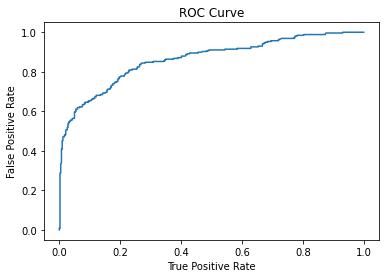

Training set areaUnderROC: 0.8630784587373036


In [ ]:
from matplotlib import pyplot as plt

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

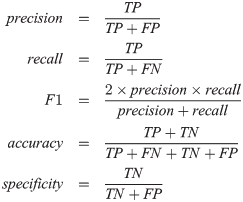

In [ ]:
lrModel.getThreshold()

0.5

In [ ]:
trainingSummary.pr.show()

+--------------------+------------------+
|              recall|         precision|
+--------------------+------------------+
|                 0.0|               1.0|
|0.003891050583657...|               1.0|
|0.007782101167315175|               1.0|
|0.007782101167315175|0.6666666666666666|
|0.011673151750972763|              0.75|
| 0.01556420233463035|               0.8|
|0.019455252918287938|0.8333333333333334|
|0.023346303501945526|0.8571428571428571|
|0.027237354085603113|             0.875|
|  0.0311284046692607|0.8888888888888888|
| 0.03501945525291829|               0.9|
|0.038910505836575876|0.9090909090909091|
|0.042801556420233464|0.9166666666666666|
| 0.04669260700389105|0.9230769230769231|
| 0.05058365758754864|0.9285714285714286|
|0.054474708171206226|0.9333333333333333|
|0.058365758754863814|            0.9375|
|  0.0622568093385214|0.9411764705882353|
| 0.06614785992217899|0.9444444444444444|
| 0.07392996108949416|              0.95|
+--------------------+------------

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


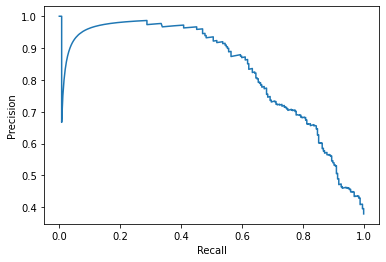

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

[The Relationship Between Precision-Recall and ROC Curves](<http://pages.cs.wisc.edu/~jdavis/davisgoadrichcamera2.pdf>)

In [ ]:
prediction = lrModel.transform(titanic_train_vec)

In [ ]:
prediction.show()

+--------+------+----+-----+-----+--------+-------------+--------------------+--------------------+--------------------+----------+
|Survived|Pclass| Age|SibSp|ParCh|    Fare|    SexVector|            features|       rawPrediction|         probability|prediction|
+--------+------+----+-----+-----+--------+-------------+--------------------+--------------------+--------------------+----------+
|       0|     1| 2.0|    1|    2|  151.55|    (1,[],[])|[1.0,2.0,1.0,2.0,...|[-3.5011398380119...|[0.02927981630729...|       1.0|
|       0|     1|50.0|    0|    0| 28.7125|    (1,[],[])|[1.0,50.0,0.0,0.0...|[-1.7061212661630...|[0.15366748243312...|       1.0|
|       0|     1|18.0|    1|    0|   108.9|(1,[0],[1.0])|[1.0,18.0,1.0,0.0...|[-0.3851322602082...|[0.40488965710381...|       1.0|
|       0|     1|19.0|    1|    0|    53.1|(1,[0],[1.0])|[1.0,19.0,1.0,0.0...|[-0.1385134664321...|[0.46542689230494...|       1.0|
|       0|     1|21.0|    0|    1| 77.2875|(1,[0],[1.0])|[1.0,21.0,0.0,1.0..

<https://spark.apache.org/docs/3.1.1/ml-tuning.html#model-selection-aka-hyperparameter-tuning>

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="Survived", rawPredictionCol="prediction", metricName="areaUnderROC")
evaluator.evaluate(prediction)

0.7747164893666183

# Полезные возможности 

In [ ]:
from pyspark.ml.feature import Imputer

df = spark.createDataFrame([
    (1.0, float("nan")),
    (2.0, float("nan")),
    (float("nan"), 3.0),
    (4.0, 4.0),
    (5.0, 5.0)
], ["a", "b"])

imputer = Imputer(inputCols=["a", "b"], outputCols=["out_a", "out_b"])
model = imputer.fit(df)

model.transform(df).show()

+---+---+-----+-----+
|  a|  b|out_a|out_b|
+---+---+-----+-----+
|1.0|NaN|  1.0|  4.0|
|2.0|NaN|  2.0|  4.0|
|NaN|3.0|  3.0|  3.0|
|4.0|4.0|  4.0|  4.0|
|5.0|5.0|  5.0|  5.0|
+---+---+-----+-----+



In [ ]:
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import Row

df = spark.createDataFrame([
    Row(userFeatures=Vectors.sparse(3, {0: -2.0, 1: 2.3})),
    Row(userFeatures=Vectors.dense([-2.0, 2.3, 0.0]))
])

slicer = VectorSlicer(inputCol="userFeatures", outputCol="features", indices=[1])

output = slicer.transform(df)

output.select("userFeatures", "features").show()

+--------------------+-------------+
|        userFeatures|     features|
+--------------------+-------------+
|(3,[0,1],[-2.0,2.3])|(1,[0],[2.3])|
|      [-2.0,2.3,0.0]|        [2.3]|
+--------------------+-------------+



# Задание
1. Собрать все этапы из раздела "Классификация" в `Pipeline`
2. Применить для классификации данных титаника RandomForest
3. Найти и сравнить F1-score для логистической регрессии (то, что есть сейчас) и случанйого леса (задание 2)

In [ ]:
!wget -c https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv

--2022-05-14 08:41:09--  https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [ ]:
titanic = spark.read.csv('/content/titanic.csv', header=True, inferSchema=True)
titanic = titanic.drop('Name')
titanic = titanic\
  .withColumnRenamed('Siblings/Spouses Aboard', 'SibSp')\
  .withColumnRenamed('Parents/Children Aboard', 'ParCh')
titanic_train, titanic_test = titanic.randomSplit([0.75, 0.25], seed=13)
titanic.show(5)

+--------+------+------+----+-----+-----+-------+
|Survived|Pclass|   Sex| Age|SibSp|ParCh|   Fare|
+--------+------+------+----+-----+-----+-------+
|       0|     3|  male|22.0|    1|    0|   7.25|
|       1|     1|female|38.0|    1|    0|71.2833|
|       1|     3|female|26.0|    0|    0|  7.925|
|       1|     1|female|35.0|    1|    0|   53.1|
|       0|     3|  male|35.0|    0|    0|   8.05|
+--------+------+------+----+-----+-----+-------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import SQLTransformer

indexer = StringIndexer(inputCol="Sex", outputCol="SexIndexer")
encoder = OneHotEncoder(inputCol="SexIndexer", outputCol="SexVector")



sql = SQLTransformer(statement="SELECT Survived, Pclass, Age, SibSp, ParCh, Fare, SexVector FROM __THIS__")






In [ ]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[indexer, encoder, sql])

model = pipeline.fit(titanic_train)
model.transform(titanic_train).show()


+--------+------+----+-----+-----+--------+-------------+
|Survived|Pclass| Age|SibSp|ParCh|    Fare|    SexVector|
+--------+------+----+-----+-----+--------+-------------+
|       0|     1| 2.0|    1|    2|  151.55|    (1,[],[])|
|       0|     1|50.0|    0|    0| 28.7125|    (1,[],[])|
|       0|     1|18.0|    1|    0|   108.9|(1,[0],[1.0])|
|       0|     1|19.0|    1|    0|    53.1|(1,[0],[1.0])|
|       0|     1|21.0|    0|    1| 77.2875|(1,[0],[1.0])|
|       0|     1|22.0|    0|    0|135.6333|(1,[0],[1.0])|
|       0|     1|24.0|    0|    0|    79.2|(1,[0],[1.0])|
|       0|     1|24.0|    0|    1|247.5208|(1,[0],[1.0])|
|       0|     1|27.0|    0|    2|   211.5|(1,[0],[1.0])|
|       0|     1|28.0|    0|    0|    31.0|(1,[0],[1.0])|
|       0|     1|28.0|    1|    0| 82.1708|(1,[0],[1.0])|
|       0|     1|29.0|    0|    0|    30.0|(1,[0],[1.0])|
|       0|     1|29.0|    1|    0|    66.6|(1,[0],[1.0])|
|       0|     1|30.0|    0|    0|     0.0|(1,[0],[1.0])|
|       0|    